In [0]:
# Importing neccessary packages
import numpy as np
import tensorflow as tf
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.listdir('.')

['.config',
 'validation',
 'drive',
 'food11.zip',
 'kaggle.json',
 'evaluation',
 'training',
 'sample_data']

### Data preparation

The dataset is seperated into 3 folders: training, validation and evaluation.
The images are named by convention as: {class_id}-{image_id}.jpg. Create subfolders inside training and validation for ImageDataGenerator to recognize classes.

In [0]:
NUM_CLASSES = 11

In [0]:
# Data augmentation for regularization and adding some extra training samples

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=30
)

In [0]:
TARGET_DIM = 224
BATCH_SIZE = 16

In [0]:
train_generator = datagen.flow_from_directory(
    directory='./training/', 
    target_size=(TARGET_DIM, TARGET_DIM),
    batch_size=BATCH_SIZE,
)

validation_generator = datagen.flow_from_directory(
    directory='./validation/',
    target_size=(TARGET_DIM, TARGET_DIM),
    batch_size=BATCH_SIZE
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [0]:
# Lets try the Resnet50 architecture

base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(TARGET_DIM, TARGET_DIM, 3)
)

In [0]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
print('Layers in resnet50: ' + str(len(base_model.layers)))

Layers in resnet50: 175


In [0]:
base_model.layers[-11].name

'conv5_block2_out'

In [0]:
preds = base_model.output
preds = tf.keras.layers.GlobalAveragePooling2D()(preds)
preds = tf.keras.layers.Dense(512, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dropout(0.5)(preds)
preds = tf.keras.layers.Dense(256, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dropout(0.3)(preds)
preds = tf.keras.layers.Dense(128, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax)(preds)

In [0]:
model = tf.keras.models.Model(base_model.input, preds)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
model.layers[-7].name

'global_average_pooling2d'

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [0]:
# Create directory in drive for storing model
!mkdir drive/My\ Drive/food_11_weights

In [0]:
# Lets define checkpoint for model saving
filepath="./drive/My Drive/food_11_weights/resnet50-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
# Freeze mobilenet layers and train only newly added layers

for layers in model.layers[:-7]:
    layers.trainable = False

for layers in model.layers[-7:]:
    layers.trainable = True

In [0]:
# Lets stop training when model acheives desired accuracy

class ModelCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs):
        # Check if validation accuracy is above 90% then stop training
        if logs['acc'] >= 0.95:
            print('Model reached its target')
            self.model.stop_training = True
            
model_callback = ModelCallback()

In [0]:
#Let's train the model 5 epochs as it will take a lot of time

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, model_callback],
    epochs=50
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
616/616 [==============================] - ETA: 0s - loss: 2.2650 - acc: 0.2081
Epoch 00001: val_acc improved from -inf to 0.14574, saving model to ./drive/My Drive/food_11_weights/resnet50-01-0.15.hdf5
616/616 [==============================] - 237s 385ms/step - loss: 2.2650 - acc: 0.2081 - val_loss: 3.7166 - val_acc: 0.1457
Epoch 2/50
616/616 [==============================] - ETA: 0s - loss: 2.1152 - acc: 0.2639
Epoch 00002: val_acc improved from 0.14574 to 0.16501, saving model to ./drive/My Drive/food_11_weights/resnet50-02-0.17.hdf5
616/616 [==============================] - 237s 384ms/step - loss: 2.1152 - acc: 0.2639 - val_loss: 23.2713 - val_acc: 0.1650
Epoch 3/50
616/616 [==============================] - ETA: 0s - loss: 2.0011 - acc: 0.3013
Epoch 00003: val_acc improved from 0.16501 to 0.27862, saving model to ./drive/My Drive/food_11_weights/resnet50-03-0.28.hdf5
616/616 [================

In [0]:
model.history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [0]:
history = model.history.history

Text(0, 0.5, 'Accuracy')

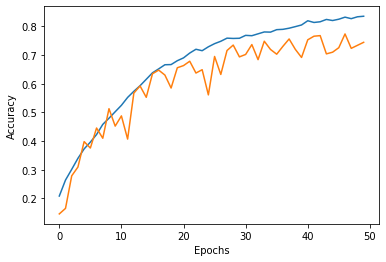

In [0]:
plt.plot(range(50), history['acc'])
plt.plot(range(50), history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Observations:

It appears that after 40 epochs model started to overfit on training data.

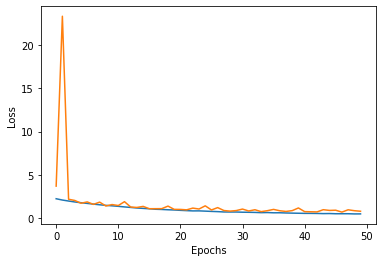

In [0]:
plt.plot(range(50), history['loss'])
plt.plot(range(50), history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()